# Chapter 2: Measuring mixtures and masks

Last access (y.m.d): 22.09.30  
Last update (y.m.d): 22.09.30

In [1996]:
import pandas as pd
import pdb
import warnings
warnings.filterwarnings(action='once')

import numpy as np
import os
import helper_fcns as hf
# import model_responses as mr
import scipy.stats as ss
import scipy.odr.odrpack as odrpack
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.backends.backend_pdf as pltSave
from matplotlib.ticker import FuncFormatter

from helper_fcns_sfBB import compute_f1f0 as bb_compute_f1f0
from helper_fcns_sfBB import get_resp_str

import plot_sf_figs as psf

# plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

%matplotlib inline

In [2171]:
# only consider experiments with full mixture set?
only_full_expt = True;
# only_full_expt = False;

In [2172]:
from matplotlib import rcParams

tex_width = 469; # per \layout in Overleaf on document
sns_offset = 2; 
hist_width = 0.9;
hist_ytitle = 0.94; # moves the overall title a bit further down on histogram plots0

rcParams.update(mpl.rcParamsDefault)

fontsz = 12;
tick_scalar = 1.5;

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : fontsz,
          'font.family': 'lmodern',
           'font.style': 'italic'}
plt.rcParams.update(params)

# rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
# rcParams['axes.linewidth'] = 2; # was 1.5
# rcParams['lines.markersize'] = 5;

tick_adj = ['xtick.major.size', 'xtick.minor.size', 'ytick.major.size', 'ytick.minor.size']
for adj in tick_adj:
    rcParams[adj] = rcParams[adj] * tick_scalar;
    
%matplotlib inline

date = '_220930'

saveName = 'figures/reports/ch02_superpos_masks%s%s/' % ('_onlyFull' if only_full_expt else '', date); # for one save name for all figures
save_loc = base_dir + saveName;

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  app.launch_new_instance()


In [2173]:
lgn_date, lgn_mod, lgn_joint = '220930', 1, 7
v1_date, v1_mod, v1_joint = '220930vE', 3, 10

thresh = 0;

lgn_suffix = '%s_%s_vT%02d_dvT%02d_jt%d' % ('LGN', lgn_date, thresh, thresh, lgn_joint)
v1_suffix = '%s_%s_vT%02d_dvT%02d_m%dj%d' % ('V1', v1_date, thresh, thresh, v1_mod, v1_joint)

lgn_jointList = hf.np_smart_load(base_dir + 'jointList_%s.npy' % lgn_suffix)
v1_jointList = hf.np_smart_load(base_dir + 'jointList_%s.npy' % v1_suffix)

In [2174]:
joints = [lgn_jointList, v1_jointList]
whichAreas = ['LGN', 'V1']

### First, trim the non-included cells from the jointList
for ii, jointList in enumerate(joints):
    # Get the keys as ints for easy indexing
    keysAsInts = np.array([int(x) for x in jointList.keys()])

    prevCells = len(jointList)
    critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['dog_varExpl'][0,-1]))[0]) > 0 for x in sorted(jointList.keys())])[0]

    jointListTrim = {key: jointList[keysAsInts[key]] for key in critA}
    joints[ii] = jointListTrim

    remCells = len(joints[ii])

    nCut = prevCells-remCells

    print('We cut %d cells (%.2f%% of the original %d)' % (nCut, 100*nCut/prevCells, prevCells))

    # also get the keys as ints for easy indexing
    keysAsInts = np.array([int(x) for x in jointList.keys()])
    
### Then, let's also re-arrange into a pandas data frame
megas = [];

for jointList, whichArea in zip(joints, whichAreas):

    ohno = pd.DataFrame.from_dict(jointList) #, orient='index')

    meta = pd.json_normalize([ohno[x]['metadata'] for x in sorted(ohno.keys())])
    metr = pd.json_normalize([ohno[x]['metrics'] for x in sorted(ohno.keys())])
    modl = pd.json_normalize([ohno[x]['model'] for x in sorted(ohno.keys())])
    supr = pd.json_normalize([ohno[x]['superpos'] for x in sorted(ohno.keys())])
    basc = pd.json_normalize([ohno[x]['basics'] for x in sorted(ohno.keys())])

    mega = pd.concat((meta, metr, modl, supr, basc), axis=1);
    
    # First, classify as simple or complex [FOR USE WITH V1]
    simple = mega['f1f0_ratio'] > 1
    msk = np.copy(simple)
    simple[~msk] = 'complex'
    simple[msk] = 'simple'
    mega['simple'] = simple
    # Then, if LGN, group all of the others together, label new type as triType
    if whichArea == 'LGN':
        cellTypes = mega['cellType'];
        non_mp = np.logical_and(~(cellTypes=='parvo'), ~(cellTypes=='magno'))
        cellTypes[non_mp] = 'other'
        mega['triType'] = cellTypes;
        
    megas.append(mega);

# Finally, unpack the trimmed dataframes
lgn_jointList, v1_jointList = megas    
# V1 layers:
v1_layers_220901 = ['', '', '', '', '', '', '', # altExp...
                    'wm', '5', '4Cb', '4Cb', '2/3', '2/3',
                    '4Ca', '4Ca', '4B', '4Ca', '4Ca', '4B', '4B',
                    '4B', '4B', '1', '4B', '4A', '2/3', '4B', '4B', 
                    '4B', '4Cb', '2/3', '6', '6', '2/3', '4Cb', '4Cb', '4Cb',
                    '4Ca', '6', '4B', '4B', '4Ca', '4B', 
                    'V2', 'V2', '5', '5', 'wm', 'wm', 'V2', 'V2',  
                    'V2', 'V2', 'V2', 'V2', 'V2', 'V2', 'V2', 'V2', 'V2', 
                    'V2', 'V2', 'V2', 'V2', 'V2', 'V2', 'V2', 'V2', # end of V1
                    '', '', '', '', '', '', '', '', '', '',
                    '', '', '', '', '', '', '', '', 
                    '', '', '', '', '', '', '', '', 
                    '', '', '', '', '', '', '', '', 
                    '', '', '', '', '', '', '', '', 
                   ];
v1_jointList['layers'] = v1_layers_220901

def group_layer(x):
    if x=='1' or x=='2/3' or x=='4A' or x=='4B':
        return -1; # supragranular
    elif x=='4Ca' or x=='4Cb':
        return 0; # input
    elif x=='5' or x=='6':
        return 1; # infragranular
    elif x=='V2':
        return 2; # for V2...
    else:
        return -99; # invalid...
grps = [group_layer(x) for x in v1_jointList['layers']]
v1_jointList['layer_groups'] = grps;
v1_jointList = v1_jointList[v1_jointList.layer_groups != 2]
v1_jointList = v1_jointList.reset_index();

# and reconstitute the megas array after this correction
megas = [lgn_jointList, v1_jointList]
# -- and unpack
lgn_jointList, v1_jointList = megas    


<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


We cut 7 cells (6.09% of the original 115)
We cut 26 cells (19.12% of the original 136)


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [2175]:
full_inds_lgn = [len(x)>2 if x is not None else False for x in lgn_jointList['byDisp']]
full_inds_v1 = [len(x)>2 if x is not None else False for x in v1_jointList['byDisp']]
# full_inds_lgn = np.delete(full_inds_lgn, 7) # why deleting 7? Really bad calculation...(see LGN/72)

# full_inds_lgn[np.where(full_inds_lgn)[0][7]] = False; # Really bad calculation, manual edit (see LGN/72)

lgn_jointList['suprExptFull'] = full_inds_lgn
v1_jointList['suprExptFull'] = full_inds_v1


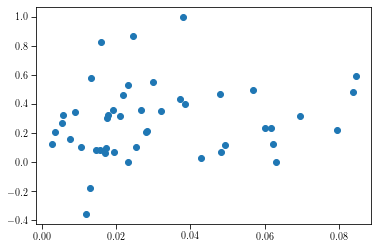

In [2176]:
val_inds = v1_jointList['suprExptFull']
plt.scatter(v1_jointList[val_inds]['sfErrsInd_var'], -v1_jointList[val_inds]['dog_mod_slope']);

In [2177]:
non_nan = np.logical_and(~np.isnan(v1_jointList[val_inds]['dog_mod_slope']), ~np.isnan(v1_jointList[val_inds]['sfErrsInd_var']))

ss.linregress(v1_jointList[val_inds]['dog_mod_slope'][non_nan], -v1_jointList[val_inds]['sfErrsInd_var'][non_nan])

LinregressResult(slope=0.013744157646270665, intercept=-0.027502409381087053, rvalue=0.15700967562343174, pvalue=0.29738128524410506, stderr=0.01303302305953373)

In [2178]:
# get color scheme
area_colors = [];
whichAreas = ['LGN', 'V1']
# toGroups = ['descrMod', 'simple']; # corresponding to LGN, V1
toGroups = ['triType', 'simple']; # corresponding to LGN, V1
megas = [lgn_jointList, v1_jointList]

for mega, whichArea, toGroup in zip(megas, whichAreas, toGroups):

    cnt = 0;
    grp_names = [];
    for nm, group in mega.groupby(toGroup, sort=False):
        cnt += 1;
        grp_names.append(nm)

    # colors = cm.viridis(np.linspace(0.15, 0.95, cnt))
    if whichArea=='V1':
        colors = sns.color_palette('viridis', n_colors=cnt-1)
        colors.append((0,0,0)); # add black!
    else:
        # why adding extra colors?
        colors = sns.color_palette('colorblind', n_colors=cnt)
        # well, the 3rd color looks like the first in viridis
#         colors = sns.color_palette('colorblind', n_colors=cnt+2)
        # so we'll add extras and swap with the desirable one
#         colors[2] = colors[4]
        
    area_colors.append(colors)

#### Start setting up for sfErrs_var metrics (preliminary metric)

In [2179]:
prince_corr = True
wider_bins = True

if wider_bins:
    max_val = 0.04 if prince_corr else 0.09 
    bins = np.arange(0, max_val, 0.0025 if prince_corr else 0.005);
else:
    max_val = 0.04 if prince_corr else 0.05 
    bins = np.arange(0, max_val, 0.0025 if prince_corr else 0.005)
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
# plt.bar(binPlotLocs, to_use, width=width, align='center', color=clr,
#             label=lbl, alpha=alphHist);
width = hist_width*stepSize;

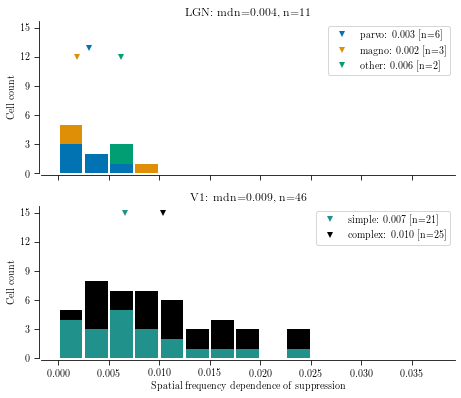

In [2180]:
nrow = 2; # LGN and V1 (all together)
# f, ax = plt.subplots(nrow, 1, figsize=(hf.set_size(tex_width, subplots=(nrow,1), extra_height=1-1/nrow)),
f, ax = plt.subplots(nrow, 1, figsize=(hf.set_size(tex_width, extra_height=1.4)),
                    sharex=True, sharey=True)

prince_str = '_prince' if prince_corr else ''

saveName = '02_01_sfErrsVar_rat%s.pdf' % (prince_str)

for (i, jl), to_srt, colors, area in zip(enumerate(megas), toGroups, area_colors, whichAreas):

    all_area = [];
    prev_height = np.zeros((len(binPlotLocs), ));

    for (nm,grp), clr in zip(jl.groupby(to_srt, sort=False), colors):

        val_inds = grp['suprExptFull'] if only_full_expt else grp['fullPath']!=0; # just a dumb way of getting all True
        vals_no_nan = grp['sfErrsInd_var%s' % prince_str][val_inds]
        clipped = [np.clip(x, clipLow, clipHigh) for x in vals_no_nan];
        vals, _ = np.histogram(clipped, bins=bins)
        vals_norm = vals/np.sum(vals)

        ax[i].bar(binPlotLocs, vals, width=width, color=clr, bottom=prev_height, align='center', )
        mdn = np.nanmedian(vals_no_nan)
        ax[i].plot(mdn, np.maximum(np.max(vals)+10, 1.4*np.max(vals)), 'v', color=clr, label='%s: %.3f [n=%d]' % ('lgn' if nm==0 else nm, mdn, np.sum(vals)))
        prev_height += vals
        
        all_area.append(grp['sfErrsInd_var%s' % prince_str][val_inds]);

    ax[i].legend();
    if i==1:
        ax[i].set_xlabel('Spatial frequency dependence of suppression');
    ax[i].set_ylabel('Cell count');
    ax[i].set_title('%s: mdn=%.3f, n=%d' % (area, np.nanmedian(np.hstack(all_area)), len(np.hstack(all_area))))
    
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(base=3 if only_full_expt else 10))
#     ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
    
sns.despine(offset=sns_offset);

f.tight_layout();

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

This will tell us simple/complex and the sfErrsInd_var, sorted by the latter's values (ascending):

In [2181]:
lgn_jointList[lgn_jointList['suprExptFull']][['sfErrsInd_var', 'triType', 'cellNum', 'simple', 'expName']].sort_values(by='sfErrsInd_var', inplace=False)

,sfErrsInd_var,triType,cellNum,simple,expName
73,0.004104,magno,80,simple,m682r17
47,0.004336,parvo,51,simple,m680p01r22
49,0.004613,parvo,53,simple,m680p01r25
50,0.004706,parvo,54,simple,m680p01r26
64,0.007320,magno,70,simple,m680p08r73
39,0.012090,parvo,43,simple,m680p01r13
71,0.012505,parvo,77,simple,m682r14
41,0.013349,parvo,45,simple,m680p01r16
72,0.018740,magno,79,simple,m682r16
37,0.039464,other,41,simple,m680p01r10


In [2008]:
v1_jointList[v1_jointList['suprExptFull']][['sfErrsInd_var', 'cellNum', 'simple', 'expName']].sort_values(by='sfErrsInd_var', inplace=False)

,sfErrsInd_var,cellNum,simple,expName
15,0.002605,10,simple,m676p03l15
10,0.003409,4,simple,m676p03l06_180_210_c036
4,0.005414,5,simple,m670l41
9,0.005635,3,simple,m676p03l06_180_210_c030
5,0.007603,6,simple,m670l46
36,0.008828,38,simple,m681p02r05_050_079_c036
27,0.010420,25,simple,m678p06l16_176_205_c043
23,0.011812,21,simple,m678p06l15_200_229_c014
28,0.012906,26,simple,m678p06l16_176_205_c069
31,0.013273,30,complex,m681p02r02_015_044_c006


Cells to consider for examples:
- Simple (must actually use F1 responses, therefore no altExp): V1/11, V1/15 (nothing else is nice...)
- Complex: V1/41, V1/44, altExp/4, 

*Why is m681p03r05 not there? V2 :(*

### Outline of experiment design, some example neurons

We'll just load an example cell to get the stimulus design

In [1786]:
expDir = 'altExp/';
which_cell = 4;
# expDir = 'V1/';
# which_cell = 40;
# expDir = 'LGN/';
# which_cell = 70;
use_hpc = True

dataPath = os.getcwd() + '/%sstructures/' % expDir
dl_name = hf.get_datalist(expDir, force_full=1)
dataList = hf.np_smart_load('%sstructures/%s' % (expDir, dl_name))
cellName = dataList['unitName'][which_cell-1];
expInd = hf.get_exp_ind(dataPath, cellName)[0]
S = hf.np_smart_load(dataPath + cellName + '_sfm.npy')
expData = S['sfm']['exp']['trial'];

loc_str = 'HPC' if use_hpc else '';

rvcName = 'rvcFits%s_220926'
phAdvName = 'phaseAdvanceFits%s_220926' % loc_str
rvcMod, rvcDir = 1, 1
vecF1 = 0; # do phAdj!

In [1787]:
f1f0_rat = hf.compute_f1f0(expData, which_cell, expInd, dataPath)[0];
respMeasure = 1 if f1f0_rat > 1 else 0;

# load rvcFits in case needed
rvcFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName=rvcName, rvcMod=rvcMod, direc=rvcDir, vecF1=vecF1);

_, stimVals, val_con_by_disp, val_by_stim_val, _ = hf.tabulate_responses(expData, expInd); # call just to get these values (not spikes/activity)

disp_levels, total_cons, sfs = stimVals;

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5121: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);


In [1909]:
def make_nice_con_labels(ax, i, which_con):
    for jj, axis in enumerate([ax[i].xaxis, ax[i].yaxis]):
        if jj == which_con and specify_ticks: # i.e. the axis which contrast?
            axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
            core_ticks = np.array([0.1, 1]);
            inter_val = 3;
            # really hacky, but allows us to put labels at 0.03/0.3 contrast, format them properly, and not add any extra labels
            axis.set_minor_formatter(FuncFormatter(lambda x,y: '%.1f' % x if np.square(x-inter_val/10)<1e-5 else '%.2f' % x if np.square(x-inter_val/100)<1e-5 else ''))
            axis.set_tick_params(which='minor', pad=5.5); # Determined by trial and error: make the minor/major align??



#### Experiment schematic

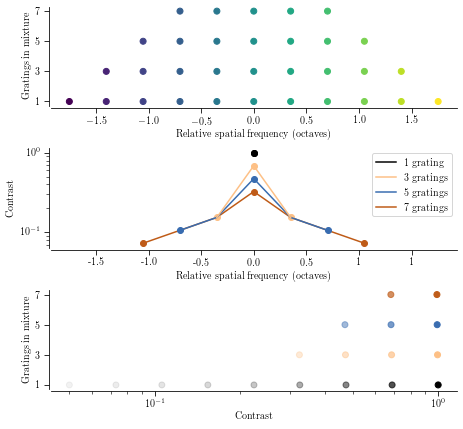

In [2026]:
nrow, ncol = 3,1
f, ax = plt.subplots(nrow, ncol, figsize=hf.set_size(tex_width, extra_height=1.5)); # extra_height=2 works

incl_single_grats = False; # include single grating contrast in the mixture
comm_x_axis = True;

saveName = '02_0_a_stimDesign%s%s.pdf' % ('_wGrats' if incl_single_grats else '', '_commonX' if comm_x_axis else '')

ref_sfs = sfs;
sf_center = np.nanmedian(ref_sfs);
ref_cons = total_cons[val_con_by_disp[0]];

sfs_color = cm.viridis(np.linspace(0,1, len(ref_sfs)));
cons_color = cm.gray(np.linspace(1, 0.1, 101));
disp_colors = cm.Accent(np.linspace(0.25, 1,len(disp_levels-1)))
# disp_colors = cm.autumn(np.linspace(0, 1,len(disp_levels-1)))
disp_colors = np.vstack(([0,0,0,1], disp_colors)); # prepend just black

for ii, disp in enumerate(disp_levels):

    # first, spatial frequencies
    curr_sf_inds = hf.get_valid_sfs(expData, ii, val_con_by_disp[ii][0], expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)
    curr_sf_vals = ref_sfs[curr_sf_inds];
    curr_sf_norm = np.log(curr_sf_vals/sf_center)
    
    ax[0].scatter(curr_sf_norm, disp*np.ones_like(curr_sf_norm), color=sfs_color[curr_sf_inds])
    if ii==0:
        ax[0].set_xlabel('Relative spatial frequency (octaves)')
        ax[0].set_ylabel('Gratings in mixture')
        ax[0].set_yticks(disp_levels)

    # then, total contrasts,
    curr_total_cons = total_cons[val_con_by_disp[ii]]
    curr_colors = np.tile(disp_colors[ii], (len(curr_total_cons), 1))
    # --- adjust alpha!
    for j, tc in enumerate(curr_total_cons):
        curr_colors[j,-1] = tc
    ax[2].scatter(curr_total_cons, disp*np.ones_like(curr_total_cons), color=curr_colors)
#     ax[1].scatter(curr_total_cons, disp*np.ones_like(curr_total_cons), color=cons_color[np.round(100*curr_total_cons).astype('int')])
    if ii==(len(disp_levels)-1):
        ax[2].set_yticks(disp_levels)
        ax[2].set_xscale('log')
        ax[2].set_xlabel('Contrast')
        ax[2].set_ylabel('Gratings in mixture')
        make_nice_con_labels(ax, 1, which_con=0)

    # finally, contrast profile
    curr_tr = hf.get_valid_trials(expData, ii, val_con_by_disp[ii][-1], np.nanmedian(curr_sf_inds).astype('int'), expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0][0]
    ex_cons = expData['con'][:, curr_tr[0]] if expDir!='altExp/' else np.array([x[curr_tr[0]] for x in expData['con']]);
    ex_sfs = expData['sf'][:, curr_tr[0]] if expDir!='altExp/' else np.array([x[curr_tr[0]] for x in expData['sf']]);
    abv_zero = np.where(ex_cons>0)[0];
    ex_sfs_norm = np.log(ex_sfs[abv_zero]/sf_center);
    ex_cons_curr = ex_cons[abv_zero]
#     ax[2].scatter(ex_sfs_norm, ex_cons_curr, color=disp_colors[ii])
    to_srt = np.argsort(ex_sfs_norm);
    # only plot the center and outermost ones?
    to_plt = [0,*abv_zero[-2:]]
    ax[1].scatter(ex_sfs_norm[to_plt], ex_cons_curr[to_plt], color=disp_colors[ii])
    ax[1].plot(ex_sfs_norm[to_srt], ex_cons_curr[to_srt], color=disp_colors[ii], label='%d grating%s' % (disp, 's' if disp>1 else ''), zorder=np.max(disp_levels)-disp)
    if ii==(len(disp_levels)-1):
        ax[1].set_yscale('log');
        ax[1].legend(loc='upper right');
        ax[1].set_xlabel('Relative spatial frequency (octaves)')
        ax[1].set_ylabel('Contrast')
        if comm_x_axis:
            ax[1].set_xlim(ax[0].get_xlim())
        # also plot all single gratings???
        if incl_single_grats:
            for x in ex_sfs_norm[to_srt]:
                ax[1].plot(x*np.ones_like(ref_cons), ref_cons, marker='o', markerfacecolor='None',alpha=0.3, mew=1, markeredgecolor='k', linestyle='None', zorder=0)
        make_nice_con_labels(ax, 2, which_con=1)

    
f.tight_layout()
sns.despine(offset=sns_offset)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

#### Example cell(s)

In [2011]:
# whichArea = 'LGN'
# cellNum = 

SyntaxError: invalid syntax (<ipython-input-2011-cf62c1b8413c>, line 2)

In [ ]:
# saveName = '02_0_b_ex_%s%03d.pdf' % (whichArea, cellNum)


### Summary metrics

#### Ability of N-R to capture mixture suppression

In [2027]:
wider_bins = True
if wider_bins:
    bins = np.linspace(0, 100, 11);
else:
    bins = np.linspace(0, 100, 11)
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
# plt.bar(binPlotLocs, to_use, width=width, align='center', color=clr,
#             label=lbl, alpha=alphHist);
width = hist_width*stepSize;

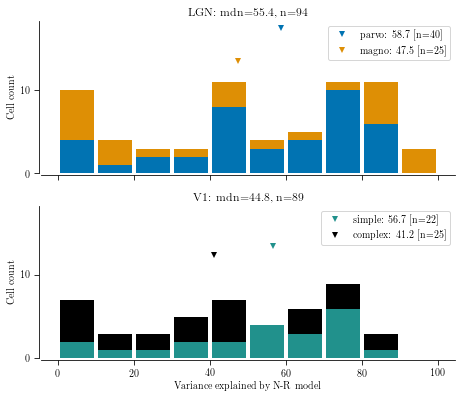

In [2028]:
nrow = 2; # LGN and V1 (all together)
f, ax = plt.subplots(nrow, 1, figsize=(hf.set_size(tex_width, extra_height=1.4)),
                    sharex=True, sharey=True)

saveName = '02_00_NR_varExpl.pdf'

if toGroups[0]=='triType': # then, skip 'other'
    skip_other = False if only_full_expt else True
else:
    skip_other = False;
    

for (i, jl), to_srt, colors, area in zip(enumerate(megas), toGroups, area_colors, whichAreas):

    all_area = [];
    prev_height = np.zeros((len(binPlotLocs), ));

    for (nm,grp), clr in zip(jl.groupby(to_srt, sort=False), colors):

        if skip_other and nm=='other':
            continue;
        
        val_inds = grp['suprExptFull'] if only_full_expt else grp['fullPath']!=0; # just a dumb way of getting all True
        vals_no_nan = grp['var_expl'][val_inds]
        clipped = [np.clip(x, clipLow, clipHigh) for x in vals_no_nan];
        vals, _ = np.histogram(clipped, bins=bins)
        vals_norm = vals/np.sum(vals)

        ax[i].bar(binPlotLocs, vals, width=width, color=clr, bottom=prev_height, align='center', )
        mdn = np.nanmedian(vals_no_nan)
        ax[i].plot(mdn, 7.5+np.max(vals), 'v', color=clr, label='%s: %.1f [n=%d]' % ('lgn' if nm==0 else nm, mdn, np.sum(vals)))
        prev_height += vals
        
        all_area.append(grp['var_expl'][val_inds]);

    ax[i].legend();
    if i==1:
        ax[i].set_xlabel('Variance explained by N-R model');
    ax[i].set_ylabel('Cell count');
    ax[i].set_title('%s: mdn=%.1f, n=%d' % (area, np.nanmedian(np.hstack(all_area)), len(np.hstack(all_area))))
    
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(base=3 if only_full_expt else 10))
#     ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
    
sns.despine(offset=sns_offset);

f.tight_layout();

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

#### Overall suppression
Measure the A.U.C. for the Naka-Rushton fit (mixture resp as function of prediction based on components in isolation) versus A.U.C. for linear prediction

In [2029]:
wider_bins = True
if wider_bins:
    bins = np.linspace(0, 1, 11);
else:
    bins = np.linspace(0, 1, 11)
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
# plt.bar(binPlotLocs, to_use, width=width, align='center', color=clr,
#             label=lbl, alpha=alphHist);
width = hist_width*stepSize;

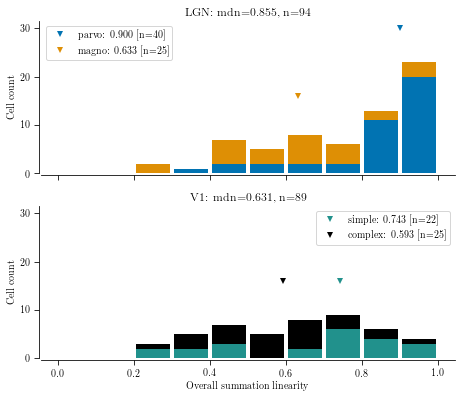

In [2030]:
nrow = 2; # LGN and V1 (all together)
# f, ax = plt.subplots(nrow, 1, figsize=(hf.set_size(tex_width, subplots=(nrow,1), extra_height=1-1/nrow)),
f, ax = plt.subplots(nrow, 1, figsize=(hf.set_size(tex_width, extra_height=1.4)),
                    sharex=True, sharey=True)

saveName = '02_02_summInd_hist.pdf'

if toGroups[0]=='triType': # then, skip 'other'
    skip_other = False if only_full_expt else True
else:
    skip_other = False;
    

for (i, jl), to_srt, colors, area in zip(enumerate(megas), toGroups, area_colors, whichAreas):

    all_area = [];
    prev_height = np.zeros((len(binPlotLocs), ));

    for (nm,grp), clr in zip(jl.groupby(to_srt, sort=False), colors):

        if skip_other and nm=='other':
            continue;
        
        val_inds = grp['suprExptFull'] if only_full_expt else grp['fullPath']!=0; # just a dumb way of getting all True
        vals_no_nan = grp['supr_area'][val_inds]
        clipped = [np.clip(x, clipLow, clipHigh) for x in vals_no_nan];
        vals, _ = np.histogram(clipped, bins=bins)
        vals_norm = vals/np.sum(vals)

        ax[i].bar(binPlotLocs, vals, width=width, color=clr, bottom=prev_height, align='center', )
        mdn = np.nanmedian(vals_no_nan)
        ax[i].plot(mdn, 10+np.max(vals), 'v', color=clr, label='%s: %.3f [n=%d]' % ('lgn' if nm==0 else nm, mdn, np.sum(vals)))
        prev_height += vals
        
        all_area.append(grp['supr_area'][val_inds]);

    ax[i].legend();
    if i==1:
        ax[i].set_xlabel('Overall summation linearity');
    ax[i].set_ylabel('Cell count');
    ax[i].set_title('%s: mdn=%.3f, n=%d' % (area, np.nanmedian(np.hstack(all_area)), len(np.hstack(all_area))))
    
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(base=3 if only_full_expt else 10))
#     ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
    
sns.despine(offset=sns_offset);

f.tight_layout();

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

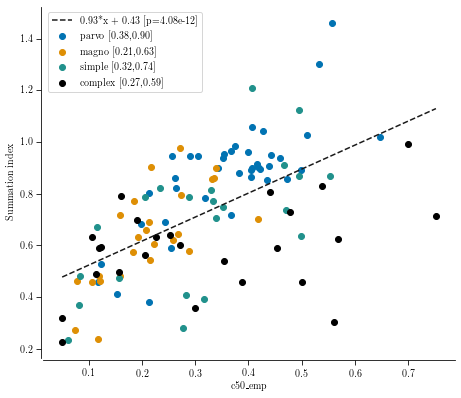

In [2035]:
f = plt.figure(figsize=(hf.set_size(tex_width, extra_height=1.4)))

which_c50 = 1; # c50, c50_emp, c50_emp_eval [1st from N-R; 2nd from optimization; 3rd is min. from numer. eval]

c50_str = 'c50' if which_c50==0 else 'c50_emp' if which_c50==1 else 'c50_emp_eval'

saveName = '02_02_summInd_scatter_%s.pdf' % (c50_str)

if toGroups[0]=='triType': # then, skip 'other'
    skip_other = False if only_full_expt else True
else:
    skip_other = False;

all_c50 = [];
all_supr_area = [];
    
for (i, jl), to_srt, colors, area in zip(enumerate(megas), toGroups, area_colors, whichAreas):

    all_area = [];
    prev_height = np.zeros((len(binPlotLocs), ));

    for (nm,grp), clr in zip(jl.groupby(to_srt, sort=False), colors):

        if skip_other and nm=='other':
            continue;
        
        val_inds = grp['suprExptFull'] if only_full_expt else grp['fullPath']!=0; # just a dumb way of getting all True
        xvals = grp['disp0_%s' % c50_str][val_inds]
        yvals = grp['supr_area'][val_inds]

        plt.scatter(xvals, yvals, color=clr, label='%s [%.2f,%.2f]' % (nm, np.nanmedian(xvals), np.nanmedian(yvals)))
        all_c50.append(xvals)
        all_supr_area.append(yvals)

plt.xlabel('%s' % c50_str.replace('_', '\_'));
# plt.xlabel(r'$c_{50}$');
plt.ylabel('Summation index');
# overall relationship:
all_x, all_y = np.array(hf.flatten_list(all_c50)), np.array(hf.flatten_list(all_supr_area))
no_nan = np.logical_and(~np.isnan(all_x), ~np.isnan(all_y));
lin_regr = ss.linregress(all_x[no_nan], all_y[no_nan])
x_plt = np.linspace(np.nanmin(all_x), np.nanmax(all_x));
plt.plot(x_plt, lin_regr.intercept + lin_regr.slope*x_plt, 'k--', label='%.2f*x + %.2f [p=%.2e]' % (lin_regr.slope, lin_regr.intercept, lin_regr.pvalue))
    
plt.legend();
sns.despine(offset=sns_offset);

f.tight_layout();

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

#### Quick check - comparing the sfErrs_var metric with and without the "Prince correction"

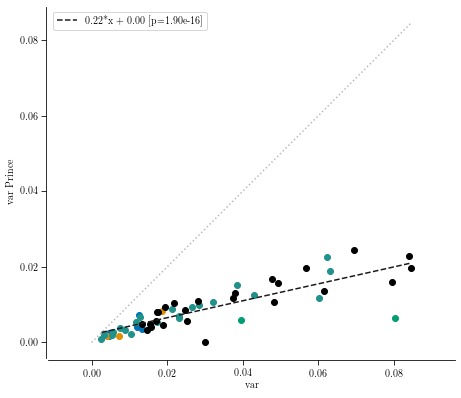

In [2249]:
f = plt.figure(figsize=(hf.set_size(tex_width, extra_height=1.4)))

saveName = '02_0000_check_w_wo_correction.pdf'

if toGroups[0]=='triType': # then, skip 'other'
    skip_other = False if only_full_expt else True
else:
    skip_other = False;

all_c50 = [];
all_supr_area = [];
    
for (i, jl), to_srt, colors, area in zip(enumerate(megas), toGroups, area_colors, whichAreas):

    all_area = [];
    prev_height = np.zeros((len(binPlotLocs), ));

    for (nm,grp), clr in zip(jl.groupby(to_srt, sort=False), colors):

        if skip_other and nm=='other':
            continue;
        
        val_inds = grp['suprExptFull'] if only_full_expt else grp['fullPath']!=0; # just a dumb way of getting all True
        xvals = grp['sfErrsInd_var'][val_inds]
        yvals = grp['sfErrsInd_var_prince'][val_inds]

        plt.scatter(xvals, yvals, color=clr)#, label='%s [%.2f,%.2f]' % (nm, np.nanmedian(xvals), np.nanmedian(yvals)))
        all_c50.append(xvals)
        all_supr_area.append(yvals)

plt.xlabel('var');
# plt.xlabel(r'$c_{50}$');
plt.ylabel('var Prince');
# overall relationship:
all_x, all_y = np.array(hf.flatten_list(all_c50)), np.array(hf.flatten_list(all_supr_area))
no_nan = np.logical_and(~np.isnan(all_x), ~np.isnan(all_y));
lin_regr = ss.linregress(all_x[no_nan], all_y[no_nan])
x_plt = np.linspace(np.nanmin(all_x), np.nanmax(all_x));
plt.plot(x_plt, lin_regr.intercept + lin_regr.slope*x_plt, 'k--', label='%.2f*x + %.2f [p=%.2e]' % (lin_regr.slope, lin_regr.intercept, lin_regr.pvalue))
max_val = np.maximum(np.nanmax(all_x), np.nanmax(all_y));
plt.plot([0, max_val], [0, max_val], 'k:', alpha=0.3)
plt.axis('equal')

plt.legend();
sns.despine(offset=sns_offset);

f.tight_layout();

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

In [2148]:
# megas[0][['sfErrsInd_var', 'sfErrsInd_var_prince', 'cellNum','suprExptFull']].head()
megas[1][['sfErrsInd_var', 'sfErrsInd_var_prince', 'cellNum','suprExptFull']].head(50)

,sfErrsInd_var,sfErrsInd_var_prince,cellNum,suprExptFull
0,0.062246,0.022652,1,True
1,0.063158,0.018829,2,True
2,0.026657,0.009399,3,True
3,0.017685,0.008011,4,True
4,0.005414,0.001948,5,True
5,0.007603,0.003923,6,True
6,0.024615,0.008635,7,True
7,0.032988,0.014129,1,False
8,0.029902,0.000048,2,True
9,0.005635,0.002863,3,True


In [2050]:
oy = hf.np_smart_load('V1/structures/superposition_analysis_220930.npy')
vey = hf.np_smart_load('LGN/structures/superposition_analysis_220930.npy')

In [2301]:
conz = np.geomspace(0.05,1,9)
print(conz)

[0.05       0.07271077 0.10573713 0.15376456 0.2236068  0.32517246
 0.4728708  0.68765602 1.        ]


In [2318]:
ncycles = 1000;
xvals = np.linspace(0, 2*np.pi*ncycles,100*ncycles)

disp=7

if disp==3:

    con_1 = conz[-2];
    con_2 = conz[3];
    
    s1 = con_1*np.sin(xvals)
    s2 = con_2*np.sin(0.2*xvals)
    s3 = con_2*np.sin(5*xvals)
    
    sig = 1+s1+s2+s3

elif disp==5:

    con_1 = conz[-3];
    con_2 = conz[3];
    con_3 = conz[2];
    
    s1 = con_1*np.sin(xvals)
    s2 = con_2*np.sin(0.8*xvals)
    s3 = con_2*np.sin((1/0.8)*xvals)
    s4 = con_3*np.sin(0.4*xvals)
    s5 = con_3*np.sin((1/0.4)*xvals)
    
    sig = 1+s1+s2+s3+s4+s5
    
elif disp==7:

    con_1 = conz[-4];
    con_2 = conz[3];
    con_3 = conz[2];
    con_4 = conz[1];
    
    s1 = con_1*np.sin(xvals)
    s2 = con_2*np.sin(0.8*xvals)
    s3 = con_2*np.sin((1/0.8)*xvals)
    s4 = con_3*np.sin(0.4*xvals)
    s5 = con_3*np.sin((1/0.4)*xvals)
    s6 = con_4*np.sin(0.2*xvals)
    s7 = con_4*np.sin((1/0.2)*xvals)
    
    sig = 1+s1+s2+s3+s4+s5+s6+s7
    
overall_reduction = np.sqrt(2*np.var(sig))
if disp==3:
    print('%.3f + %.3f + %.3f = %.3f' % (con_1,con_2,con_2,overall_reduction))
elif disp==5:
    print('%.3f + %.3f + %.3f + %.3f + %.3f = %.3f' % (con_1,con_2,con_2,con_3,con_3,overall_reduction))
elif disp==7:
    print('%.3f + %.3f + %.3f + %.3f + %.3f + %.3f + %.3f = %.3f' % (con_1,con_2,con_2,con_3,con_3,
                                                                     con_4, con_4, overall_reduction))
# plt.plot(xvals, 1+s1+s2)

0.325 + 0.154 + 0.154 + 0.106 + 0.106 + 0.073 + 0.073 = 0.431


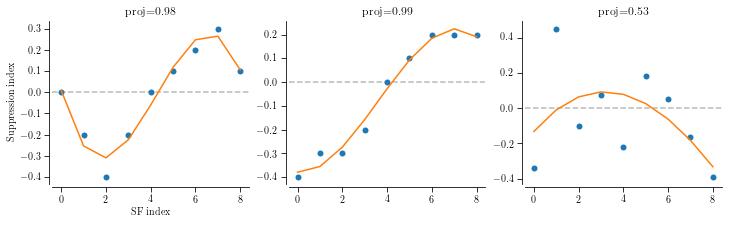

In [2380]:
f, ax = plt.subplots(1, 3, figsize=(12,3))

x = [0, -0.2, -0.4, -0.2, 0, 0.1, 0.2, 0.3, 0.1] # tri-phasic
y = [-0.4, -0.3, -0.3, -0.2, 0, 0.1, 0.2, 0.2, 0.2] # linear
z = [np.random.rand()-0.5 for i in range(len(x))]

for iii,vals in enumerate([x,y,z]):

    xv = np.arange(len(vals))
    pf = np.polyfit(xv, vals, deg=3)
    ax[iii].axhline(0, color='k', linestyle='--', alpha=0.3)
    ax[iii].plot(xv, vals, 'o')
    p = np.poly1d(pf);
    proj = np.corrcoef(vals, p(xv))[0,1]
#     proj = np.sum(np.multiply(vals, p(xv)))
#     print(np.multiply(vals,p(xv)))
    ax[iii].plot(xv, p(xv))
    ax[iii].set_title('proj=%.2f' % proj);
    
ax[0].set_ylabel('Suppression index')
ax[0].set_xlabel('SF index')
sns.despine(offset=3)
    
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + 'errMetric_simulation.pdf');
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

### Better superposition analysis!
22.09.20

- 1. Ask if number of mixtures (i.e. stimulus width) is related to strength of suppression, i.e. relative failure 
of superposition
    - This one is only relevant for full mixture sets (i.e. V1 and small subset of LGN)
- 2. Blah

In [1616]:
expDir = 'V1/';
which_cell = 40;
use_hpc = True

dataPath = os.getcwd() + '/%sstructures/' % expDir
dl_name = hf.get_datalist(expDir, force_full=1)
dataList = hf.np_smart_load('%sstructures/%s' % (expDir, dl_name))
cellName = dataList['unitName'][which_cell-1];
expInd = hf.get_exp_ind(dataPath, cellName)[0]
S = hf.np_smart_load(dataPath + cellName + '_sfm.npy')
expData = S['sfm']['exp']['trial'];

loc_str = 'HPC' if use_hpc else '';

rvcName = 'rvcFits%s_220531' % loc_str if expDir=='LGN/' else 'rvcFits%s_220718' % loc_str
phAdvName = 'phaseAdvanceFits%s_220531' % loc_str if expDir=='LGN/' else 'phaseAdvanceFits%s_220718' % loc_str;
rvcMod, rvcDir = 1, 1
vecF1 = 0; # do phAdj!

In [1617]:
import plot_superposition_func as psf

In [1618]:
autoreload.reload(psf); autoreload.reload(hf);

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/plot_superposition_func.py:981: DeprecationWarning: invalid escape sequence \_
  fSuper.suptitle('%s %s#%d [%s]; f1f0 %.2f; szSupr[dt/md] %.2f/%.2f; oriBW|CV %.2f|%.2f; tfBW %.2f]' % (cellType, '\\' if useTex else '', which_cell, cell_name_use, f1f0_rat, suprDat, suprMod, oriBW, oriCV, tfBW), fontsize=fnt_sz, y=1-0.03*simple_plot)


In [1619]:
f1f0_rat = hf.compute_f1f0(expData, which_cell, expInd, dataPath)[0];
respMeasure = 1 if f1f0_rat > 1 else 0;

# load rvcFits in case needed
rvcFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName=rvcName, rvcMod=rvcMod, direc=rvcDir, vecF1=vecF1);

_, stimVals, val_con_by_disp, val_by_stim_val, _ = hf.tabulate_responses(expData, expInd); # call just to get these values (not spikes/activity)
resps_data, respAll, respsPhAdv_mean_ref, respsPhAdv_mean_preds, baseline, comp_resp_org, val_tr_org = psf.get_responses(expData, which_cell, expInd, expDir,
                                                                                              dataPath, respMeasure, stimVals, val_con_by_disp, rvcFits, 
                                                                                              phAdvName, vecF1, rvcDir=rvcDir, val_by_stim_val=val_by_stim_val);

predResps = resps_data[2] if respsPhAdv_mean_preds is None else respsPhAdv_mean_preds;
respMean = resps_data[0] if respsPhAdv_mean_ref is None else respsPhAdv_mean_ref; # equivalent to resps[0];   

resp_std = resps_data[1]
pred_std = resps_data[3]

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5121: RuntimeWarning: Mean of empty slice
  spikes = data['f1']
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);


In [1620]:
# only use mixtures for fitting suppression
all_resps_fit = respMean[1:, :, :].flatten()
all_preds_fit = predResps[1:, :, :].flatten()

fitz, rel_c50, nr_mod = psf.fit_overall_suppression(all_resps_fit, all_preds_fit) 

In [1621]:
# broadcast disps/cons/sfs for use
disps_expand = np.broadcast_to(np.expand_dims(np.expand_dims(stimVals[0], axis=-1), axis=-1), respMean.shape)
cons_expand = np.broadcast_to(np.expand_dims(np.expand_dims(stimVals[1], axis=0), axis=0), respMean.shape)
sfs_expand = np.broadcast_to(np.expand_dims(np.expand_dims(stimVals[2], axis=0), axis=-1), respMean.shape)

In [1622]:
mixture_exp = pd.DataFrame(data=np.column_stack((disps_expand.flatten(), sfs_expand.flatten(), cons_expand.flatten(), respMean.flatten(), resp_std.flatten(), predResps.flatten(), pred_std.flatten())), 
                      columns=['disp', 'sf', 'total_con', 'respMean', 'respStd', 'predMean', 'predStd'], dtype=np.float32)
# drop the NaN conditions (i.e. no respMean and/or no predMean for a given dispXconXsf)
mixture_exp = mixture_exp.dropna(subset=['respMean', 'predMean'], )
# and add the model prediction given the input drive (i.e. predMean)
mixture_exp['mod_pred'] = np.maximum(nr_mod(mixture_exp['predMean'], *fitz), 0.5)

mixute_exp_mixs = mixture_exp[mixture_exp['disp']>1];

to_use = mixute_exp_mixs;


In [1623]:
#### Now, recapitulate the key measures from before -->

# 1. Relative suppression (expected/measured)
to_use['rel_err'] = to_use['respMean'] - to_use['mod_pred']
# 2. Suppression index  [r-p]/[r+p]
to_use['supr_ind'] = (to_use['respMean']-to_use['mod_pred'])/(to_use['respMean']+to_use['mod_pred'])
# 3. rel. supr
to_use['rel_supr'] = to_use['respMean']/to_use['mod_pred']


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### i. Using only contrasts/sfs which appear in all dispersions, is there a difference in relative suppression?

In [1624]:
which_grat_as_ref = to_use['disp'].unique()[-1]; # use the largest # of grats as the reference
valid_sf_cons = to_use[to_use['disp']==which_grat_as_ref][['sf', 'total_con']].values

In [1629]:
oy = [];
which_metr = 'rel_supr'
# which_metr = 'supr_ind'
for comb in valid_sf_cons:
    oy.append(to_use[np.logical_and(np.isclose(to_use['sf'], comb[0]), np.isclose(to_use['total_con'], comb[1], atol=0.02))].groupby('disp')[which_metr].mean())
vey = pd.DataFrame(oy)

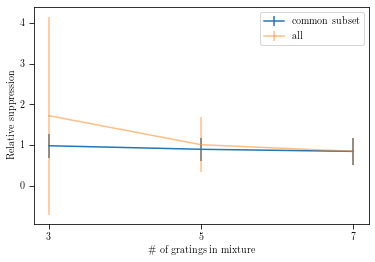

In [1630]:
disp_vals = to_use['disp'].unique()
ndisps = len(disp_vals)
plt.errorbar(disp_vals, vey.mean(), yerr=vey.std(), label='common subset');
mn, std = to_use.groupby('disp')[which_metr].mean(), to_use.groupby('disp')[which_metr].std();
plt.errorbar(disp_vals, mn, std, label='all', alpha=0.5);
plt.xlabel('\# of gratings in mixture');
plt.ylabel('Relative suppression');
plt.xticks(ticks=disp_vals);
plt.legend();


### II. Component responses for f1s...

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


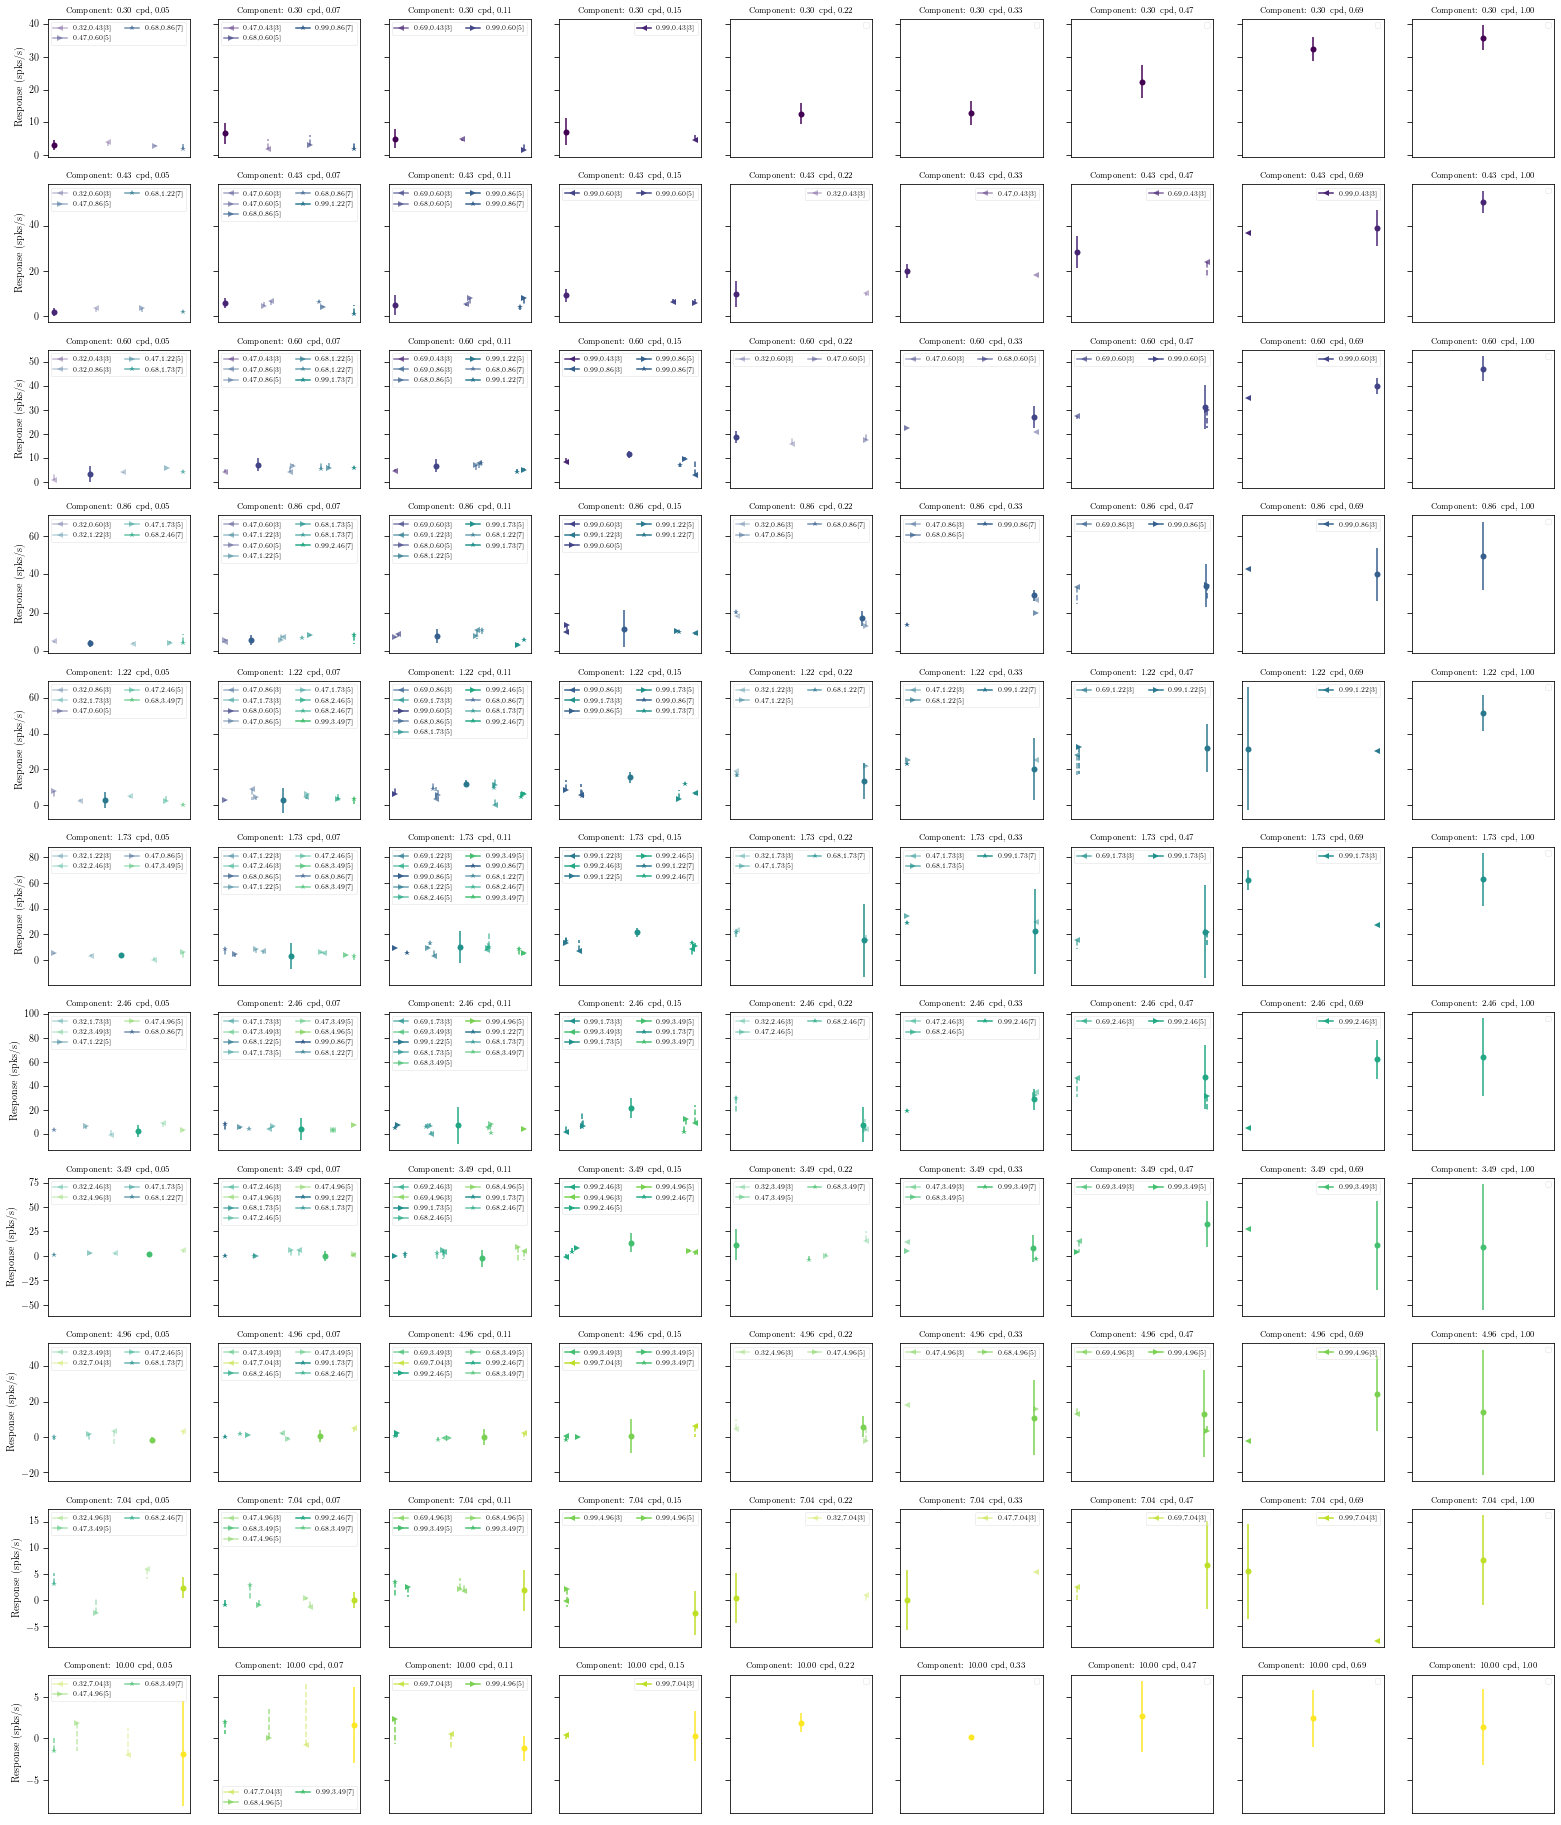

In [1323]:
# here are the single grating sfs/cons to consider
specify_ticks = True
isol_pred = True;

disp_mixes = [];

if comp_resp_org is not None:

    marker_by_disp = ['', '<', '>', '*']
    
    save_loc_curr = save_loc + '02_02_byComp/'
    saveName = '%s%02d%s.pdf' % (expDir.replace('/', '_'), which_cell, '_wPred' if isol_pred else '')
    save_loc_disp = save_loc + '02_02_byDisp/'
    saveName_disps = '%s%02d.pdf' % (expDir.replace('/', '_'), which_cell)
    
    con_inds = val_con_by_disp[0];
    disps, sfs, cons, all_cons = stimVals[0], stimVals[2], stimVals[1][val_con_by_disp[0]], stimVals[1];
    nsfs, ncons = len(sfs), len(cons);

    clrs = cm.viridis(np.linspace(0, 1, nsfs))

    f, ax = plt.subplots(nrows=nsfs, ncols=ncons, figsize=(ncons*3,nsfs*3), sharey='row')

    # plot isol. component responses
    for d in range(1,len(disps)):

        curr_subset = to_use[to_use['disp']==disps[d]]
        curr_mix_sfs, curr_mix_cons = to_use[to_use['disp']==disps[d]]['sf'].unique(), to_use[to_use['disp']==disps[d]]['total_con'].unique()
        g, disp_ax = plt.subplots(nrows=len(curr_mix_sfs), ncols=len(curr_mix_cons), 
                                  figsize=(len(curr_mix_cons)*3,len(curr_mix_sfs)*2.5), sharex=True, sharey=True)
        
        for sf_ind_mix, con_ind_mix in itertools.product(range(val_tr_org.shape[1]), range(val_tr_org.shape[2])):

            if np.all(np.isnan(comp_resp_org[d, sf_ind_mix, con_ind_mix])):
                continue;
                
            disp_con_ind = np.where(all_cons[con_ind_mix] == curr_mix_cons)[0][0]
            disp_sf_ind = np.where(sfs[sf_ind_mix] == curr_mix_sfs)[0][0]

            # How much was the mixture response as a fraction of the prediction, i.e. overall mixture response suppressed?
            overall_red = respMean[d, sf_ind_mix, con_ind_mix]/predResps[d, sf_ind_mix, con_ind_mix]
            
            # Otherwise, we have a valid reponse!               
            curr_trials = hf.nan_rm(val_tr_org[d, sf_ind_mix, con_ind_mix])
            curr_sfs_plt = [];
            for comp_i, resp_i in enumerate(comp_resp_org[d, sf_ind_mix, con_ind_mix]):
                curr_sf, curr_con = np.unique(expData['sf'][comp_i, curr_trials.astype('int')]), np.unique(expData['con'][comp_i, curr_trials.astype('int')])
                sf_ind = np.where(np.isclose(curr_sf, sfs, atol=0.001))[0][0]
                con_ind = np.where(np.isclose(curr_con, cons, atol=0.01))[0][0]
                
                ### plot the isolated component response - first, organized by component
                rand_xoffset = hf.random_in_range([0,0.3])[0];
                if curr_sf==sfs[sf_ind_mix]:
                    rand_sgn = np.sign(np.random.rand()-0.5); # just to avoid values showing up exactly on top of the specific response
                    rand_xloc = rand_sgn*(1.01 + hf.random_in_range([0, 0.04])[0]);
                else: # scale the distance according to how far the mixture SF was from the current SF component
                    rel_step = np.log2(sfs[sf_ind_mix]/curr_sf)
                    rand_xloc = 1 + rel_step*hf.random_in_range([0.05, 0.07])[0];
#                 else: # i.e. the mixture sf is above the current sf
#                     rand_xloc = 1 + hf.random_in_range([0.075, 0.5])[0];
                ax[sf_ind, con_ind].plot(rand_xloc, resp_i, color=clrs[sf_ind_mix], alpha=all_cons[con_ind_mix], 
                                         marker=marker_by_disp[d], label='%.2f,%.2f[%d]' % (all_cons[con_ind_mix], sfs[sf_ind_mix], disps[d]))
                if isol_pred:
                    pred_i = respMean[0, sf_ind, con_ind] * overall_red
                    ax[sf_ind, con_ind].plot(rand_xloc, pred_i, color=clrs[sf_ind_mix], alpha=all_cons[con_ind_mix],
                                 marker=marker_by_disp[d], fillstyle='none')
                    # and plot connecting line
                    ax[sf_ind, con_ind].plot([rand_xloc, rand_xloc], [resp_i, pred_i], color=clrs[sf_ind_mix], alpha=all_cons[con_ind_mix],
                                 marker=None, linestyle='--')
                
                ### - then, organized by mixture: get the current SF (to plot all components together), and plot the isol. response
                curr_sfs_plt.append(sfs[sf_ind]);
                disp_ax[disp_sf_ind, disp_con_ind].errorbar(sfs[sf_ind], respMean[0, sf_ind, con_inds[con_ind]],
                                         resp_std[0, sf_ind, con_inds[con_ind]], marker='o', color=clrs[sf_ind])
            ### For byDisp organization, plot it together (with lines connecing the isolated mixture responses)
            sf_order = np.argsort(curr_sfs_plt)
            disp_ax[disp_sf_ind, disp_con_ind].semilogx(np.array(curr_sfs_plt)[sf_order], 
                                                    np.array(comp_resp_org[d, sf_ind_mix, con_ind_mix])[sf_order], '-o');
            if disp_con_ind==0: # i.e. left-most column
                disp_ax[disp_sf_ind, disp_con_ind].set_ylabel('Response (spks/s)')
            if disp_sf_ind==(len(curr_mix_sfs)-1): # bottom row
                disp_ax[disp_sf_ind, disp_con_ind].set_xlabel('Spatial frequency (c/deg)');
            log_supr = np.log2(overall_red) if overall_red>0 else np.nan
            disp_ax[disp_sf_ind, disp_con_ind].set_title('Mix: %.2f cpd, %.2f [log(supr)=%.2f]' % (sfs[sf_ind_mix], all_cons[con_ind_mix], log_supr))
            
            # format to have integers (not scientific notation)
            for jj, axis in enumerate([disp_ax[disp_sf_ind, disp_con_ind].xaxis, disp_ax[disp_sf_ind, disp_con_ind].yaxis]):
                axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
                if jj == 0 and specify_ticks: # i.e. x-axis
                    core_ticks = np.array([1]);
                    if np.min(sfs)<=0.2:
                        core_ticks = np.hstack((0.1, core_ticks));
                    if np.max(sfs)>=7:
                        core_ticks = np.hstack((core_ticks, 10));
                    axis.set_ticks(core_ticks)
                    # really hacky, but allows us to put labels at 0.3/3 cpd, format them properly, and not add any extra labels
                    inter_val = 3;
                    axis.set_minor_formatter(FuncFormatter(lambda x,y: '%d' % x if np.square(x-inter_val)<1e-3 else '%.1f' % x if np.square(x-inter_val/10)<1e-3 else '')) # this will make everything in non-scientific notation!
                    axis.set_tick_params(which='minor', pad=5.5); # Determined by trial and error: make the minor/major align??
            
            g.tight_layout();
            sns.despine(offset=5, ax=disp_ax[disp_sf_ind, disp_con_ind]);
        # DONE WITH LOOP OVER ALL CONDITIONS
        disp_mixes.append(g);
           
    # then plot isolated responses
    for sf_ind,con_ind in itertools.product(range(len(sfs)), range(len(cons))):
        ax[sf_ind, con_ind].errorbar(1, respMean[0, sf_ind, con_inds[con_ind]], resp_std[0, sf_ind, con_inds[con_ind]], marker='o', color=clrs[sf_ind]);
        ax[sf_ind, con_ind].legend(fontsize='x-small', framealpha=0.3, ncol=2);
        ax[sf_ind, con_ind].set_title('Component: %.2f cpd, %.2f' % (sfs[sf_ind], cons[con_ind]), fontsize='small');
        if con_ind==0:
            ax[sf_ind, con_ind].set_ylabel('Response (spks/s)')
        ax[sf_ind, con_ind].xaxis.set_visible(False)
        
#     f.tight_layout();

    # now save
    if not os.path.exists(save_loc_curr):
        os.makedirs(save_loc_curr)
    pdfSv = pltSave.PdfPages(save_loc_curr + saveName);
    pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
    pdfSv.close()
    
    # and save
    if not os.path.exists(save_loc_disp):
        os.makedirs(save_loc_disp)
    pdfSv = pltSave.PdfPages(save_loc_disp + saveName_disps);
    for gg in disp_mixes:
        pdfSv.savefig(gg)
        plt.close(gg)
    pdfSv.close();



### Recapitulate some of the key aspects from before!

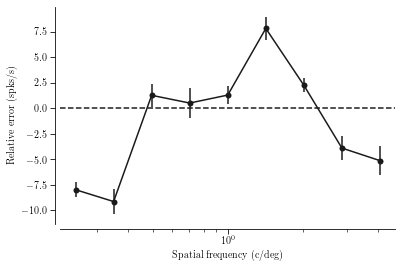

In [1402]:
use_std = False
sfs = np.unique(to_use['sf']);
mns, std, counts = to_use.groupby('sf')['rel_err'].mean(), to_use.groupby('sf')['rel_err'].std(), to_use.groupby('sf')['rel_err'].count()
var_to_use = std if use_std else std/counts
plt.errorbar(sfs, mns, yerr=var_to_use, color='k', linestyle='-', marker='o');
plt.xscale('log');
plt.axhline(0, color='k', linestyle='--');
plt.xlabel('Spatial frequency (c/deg)');
plt.ylabel('Relative error (spks/s)');
# plt.ylim([-30,30])
sns.despine(offset=5);

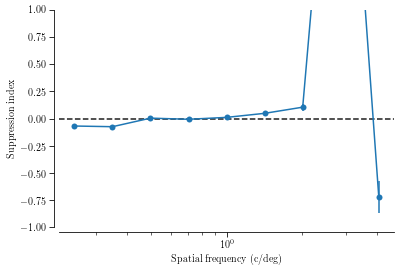

In [1401]:
sfs = np.unique(to_use['sf']);
mns, sems = to_use.groupby('sf')['supr_ind'].mean(), to_use.groupby('sf')['supr_ind'].std()/to_use.groupby('sf')['supr_ind'].count()
plt.errorbar(sfs, mns, yerr=sems, marker='o');
plt.xscale('log')
plt.axhline(0, color='k', linestyle='--');
plt.xlabel('Spatial frequency (c/deg)');
plt.ylabel('Suppression index');
plt.ylim([-1,1]);
sns.despine(offset=5);

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1692: RuntimeWarning: invalid value encountered in power
  


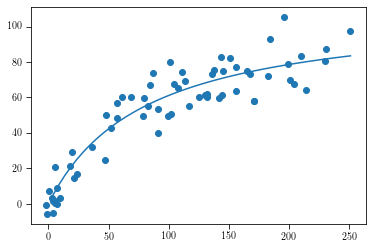

In [1400]:
preds_no_nans = hf.nan_rm(all_preds_fit)
xvals = np.linspace(np.nanmin(preds_no_nans), np.nanmax(preds_no_nans))
plt.plot(xvals, nr_mod(xvals, *fitz));

plt.scatter(all_preds_fit, all_resps_fit)